In [1]:
import sys; sys.path.append(_dh[0].split("knowknow")[0])
from knowknow import *

database_name = 'wos'

In [7]:
cysum = load_variable("%s.cysum" % database_name)

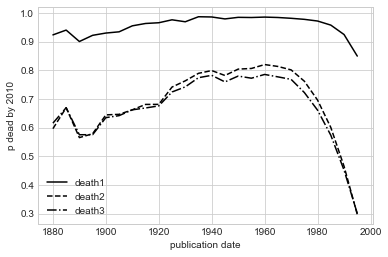

In [9]:
dying_count = defaultdict(lambda:defaultdict(int))

step = 5

for x in cysum.values():
    for dk in ['death1','death2','death3']:
        dying_count[dk][(
            (x['pub']//step)*step,
            x[dk] is not None
        )] += 1

counts = range(1880,2000,step)

linestyles = ['-','--','-.']

for i,dk in enumerate(['death1','death2','death3']):
    probs = [ dying_count[dk][(c,True)]/(dying_count[dk][(c,True)]+dying_count[dk][(c,False)]) if (dying_count[dk][(c,True)]+dying_count[dk][(c,False)]>0) else 0 for c in counts ]
    plt.plot(counts,probs,label=dk,linestyle=linestyles[i], color='black')

plt.xlabel("publication date")
plt.ylabel("p dead by 2010")
plt.legend();